In [1]:
import pandas as pd
import numpy as np
import re
import operator
import nltk
import string

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from nltk.classify import textcat
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import PorterStemmer 

# nltk.download('punkt');
# nltk.download('averaged_perceptron_tagger');
# nltk.download('crubadan');
# nltk.download('stopwords');

In [22]:
## Read data

df = pd.read_csv('Bacchanal-Buffet-reviews.csv', parse_dates=['date'], lineterminator='\n')

In [23]:
## Remove reviews that are not written in English

def is_english(s):
    # Texts that include words written in French (e.g., crème brûlée) 
    # are not classified as written in English
    return s.isascii()

texts = df['text'].tolist()
i_texts_english = [i for i, text in enumerate(texts) if is_english(text)]
df_english = df.iloc[i_texts_english, :]

In [5]:
## Clean the text data

# Stemming?
# Lemmatization?

ps = PorterStemmer()

def clean_text(text, K=1, stemming=False):
    tokens = text.split()
    
    # Remove punctuation
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]

    # Remove words that are not purely comprised of alphabetical characters
    tokens = [w for w in tokens if w.isalpha()]
    
    # Transform the text into lowercase letters
    tokens = [w.lower() for w in tokens]
    
    # Stem the words
    if stemming:
        tokens_stemmed = [ps.stem(w) for w in tokens]
        tokens = list(set(tokens_stemmed))
    
    # Remove stop words
    stop_words = stopwords.words('english')
    tokens = [w for w in tokens if not w in stop_words]
    
    # Remove words that contain fewer than K+1 characters
    tokens = [w for w in tokens if len(w) > K]
    
    return tokens

texts_english = df_english['text'].tolist()
texts_tokenized = [clean_text(text, K=2) for text in texts_english]

print(texts_tokenized[0])

['getting', 'food', 'poisoning', 'palms', 'hotel', 'scared', 'eat', 'buffets', 'figured', 'high', 'price', 'tag', 'positive', 'reviews', 'etc', 'worth', 'chance', 'really', 'glad', 'gave', 'try', 'btw', 'uploaded', 'collage', 'things', 'ate', 'seafood', 'line', 'far', 'longest', 'would', 'recommend', 'showing', 'heels', 'youre', 'female', 'feet', 'killing', 'line', 'door', 'line', 'get', 'sat', 'seafood', 'line', 'totally', 'worth', 'though', 'prime', 'rib', 'best', 'ive', 'ever', 'loved', 'sweet', 'potato', 'tots', 'even', 'pho', 'music', 'great', 'server', 'alma', 'older', 'gentleman', 'mustache', 'attentive', 'delightful', 'return', 'next', 'trip', 'comfortable', 'shoes', 'horrible', 'visit', 'palms', 'non', 'stop', 'issues', 'matter', 'hours', 'establishment', 'truly', 'high', 'light', 'trip', 'thank', 'exquisite', 'dinner']


21043
[('buffet', 13233), ('food', 11308), ('good', 6986), ('line', 5246), ('get', 5183), ('crab', 5018), ('vegas', 4911), ('time', 4788), ('wait', 4712), ('like', 4331), ('best', 3999), ('one', 3991), ('worth', 3723), ('seafood', 3632), ('great', 3572), ('legs', 3421), ('would', 3413), ('place', 3295), ('really', 3262), ('back', 3179), ('buffets', 3002), ('dessert', 2964), ('price', 2871), ('bacchanal', 2784), ('try', 2769), ('also', 2753), ('station', 2695), ('dinner', 2686), ('much', 2679), ('everything', 2662), ('quality', 2654), ('dont', 2625), ('service', 2614), ('selection', 2547), ('eat', 2456), ('even', 2437), ('fresh', 2422), ('got', 2410), ('long', 2371), ('better', 2280), ('come', 2249), ('went', 2242), ('didnt', 2205), ('well', 2169), ('definitely', 2126), ('section', 2014), ('desserts', 1958), ('around', 1942), ('pretty', 1897), ('variety', 1887)]
[('feelstastes', 1), ('awed', 1), ('fights', 1), ('buffetpricey', 1), ('sugarlessfatfree', 1), ('ribetc', 1), ('electricity', 

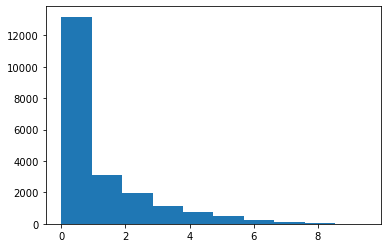

In [6]:
## Create a vocabulary

vocabulary = Counter()

for tokens in texts_tokenized:
    vocabulary.update(tokens)

# Print the size of the vocabulary
print(len(vocabulary))

# Print the top words in the vocabulary
print(vocabulary.most_common(50))

# Print the least common words in the vocabulary
print(vocabulary.most_common()[:-50:-1])

_, ax = plt.subplots();
ax.hist(np.log(list(vocabulary.values())));
plt.show();

In [21]:
## Remove words that have low occurrence in the corpus

min_occurance = 50
tokens = [k for k, c in vocabulary.items() if c >= min_occurance]

print(tokens[:50])

print(len(tokens))

['getting', 'food', 'poisoning', 'hotel', 'eat', 'buffets', 'figured', 'high', 'price', 'tag', 'positive', 'reviews', 'etc', 'worth', 'chance', 'really', 'glad', 'gave', 'try', 'btw', 'things', 'ate', 'seafood', 'line', 'far', 'would', 'recommend', 'youre', 'get', 'sat', 'totally', 'though', 'prime', 'rib', 'best', 'ive', 'ever', 'loved', 'sweet', 'potato', 'tots', 'even', 'pho', 'music', 'great', 'server', 'attentive', 'return', 'next', 'trip']
1577


In [18]:
## Create a term-document matrix

# Create a dictionary from the most common tokens in the vocabulary
vocabulary_final = dict(zip(tokens, range(len(tokens))))

vectorizer = CountVectorizer(analyzer=clean_text, vocabulary=vocabulary_final)
X = vectorizer.fit_transform(texts_english)

# Create DataFrame
df_tdm = pd.DataFrame(X.toarray().transpose(), index = vectorizer.get_feature_names()).T

df_tdm

,getting,food,poisoning,hotel,eat,buffets,figured,high,price,tag,...,snails,bachannal,banana,lover,speak,mark,standards,treats,overhyped,picked
0,1,1,1,1,1,1,1,2,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9683,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9684,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9685,1,2,0,0,0,0,0,1,2,0,...,0,0,0,0,0,0,0,0,0,0
9686,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
## Save data to files

df_tdm.to_csv('X.csv', index=False)
df_english['useful'].to_csv('Y.csv', index=False)

In [ ]:
### OLD ###

# Find unique words in all reviews

unique_words = set()

texts = df_english['text'].tolist()

for text in texts:
    words = re.findall(r'\w+', text)
    words = [word for word in words if word.isalpha()]  # Remove words that contain numbers
    unique_words.update(words)

print('There are ' + str(len(unique_words)) + ' unique words.')

# Count the number of occurences of each unique word

words_freqs = dict.fromkeys(unique_words, 0)

for text in texts:
    words = re.findall(r'\w+', text)
    # Remove words that contain numbers
    words = [word for word in words if word.isalpha()]
    for word in words:
        words_freqs[word] += 1

words_freqs_sorted = sorted(words_freqs.items(), key=operator.itemgetter(1), reverse=True)

# Remove words that should not influence the meaning of the text

relevant_words = []

for word, _ in words_freqs_sorted:
    token = nltk.word_tokenize(word)
    tag = nltk.pos_tag(token)[0][1]
    if tag.startswith('J') or tag.startswith('N') or tag.startswith('RB') or tag.startswith('V'):
        relevant_words.append(word)

print('There are ' + str(len(relevant_words)) + ' meaningful words.')